In [17]:
# import block 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

# for normalize
from sklearn.preprocessing import MinMaxScaler

# for balance data
from statistics import mode

# plotting
from matplotlib.colors import ListedColormap

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import adjusted_rand_score

from sklearn.mixture import GaussianMixture

from scipy.cluster.hierarchy import dendrogram, linkage

from scipy.cluster.hierarchy import fcluster

Part 1: Data Exploration and Subsetting

1. Load the RNA-seq dataset and display the shape to show the number of samples and
genes.

In [18]:
rnaSeqDf = pd.read_csv('/Users/peytonhall/downloads/data.csv')

In [19]:
# very large dataset, shape is (801, 20532)
# 800 samples
# 20530 genes
print(rnaSeqDf.shape)
print(rnaSeqDf.head())

(801, 20532)
  Unnamed: 0  gene_0    gene_1    gene_2    gene_3     gene_4  gene_5  \
0   sample_0     0.0  2.017209  3.265527  5.478487  10.431999     0.0   
1   sample_1     0.0  0.592732  1.588421  7.586157   9.623011     0.0   
2   sample_2     0.0  3.511759  4.327199  6.881787   9.870730     0.0   
3   sample_3     0.0  3.663618  4.507649  6.659068  10.196184     0.0   
4   sample_4     0.0  2.655741  2.821547  6.539454   9.738265     0.0   

     gene_6    gene_7  gene_8  ...  gene_20521  gene_20522  gene_20523  \
0  7.175175  0.591871     0.0  ...    4.926711    8.210257    9.723516   
1  6.816049  0.000000     0.0  ...    4.593372    7.323865    9.740931   
2  6.972130  0.452595     0.0  ...    5.125213    8.127123   10.908640   
3  7.843375  0.434882     0.0  ...    6.076566    8.792959   10.141520   
4  6.566967  0.360982     0.0  ...    5.996032    8.891425   10.373790   

   gene_20524  gene_20525  gene_20526  gene_20527  gene_20528  gene_20529  \
0    7.220030    9.119813 

In [20]:
geneExpression = rnaSeqDf.iloc[:,1:]
print(geneExpression)

     gene_0    gene_1    gene_2    gene_3     gene_4  gene_5    gene_6  \
0       0.0  2.017209  3.265527  5.478487  10.431999     0.0  7.175175   
1       0.0  0.592732  1.588421  7.586157   9.623011     0.0  6.816049   
2       0.0  3.511759  4.327199  6.881787   9.870730     0.0  6.972130   
3       0.0  3.663618  4.507649  6.659068  10.196184     0.0  7.843375   
4       0.0  2.655741  2.821547  6.539454   9.738265     0.0  6.566967   
..      ...       ...       ...       ...        ...     ...       ...   
796     0.0  1.865642  2.718197  7.350099  10.006003     0.0  6.764792   
797     0.0  3.942955  4.453807  6.346597  10.056868     0.0  7.320331   
798     0.0  3.249582  3.707492  8.185901   9.504082     0.0  7.536589   
799     0.0  2.590339  2.787976  7.318624   9.987136     0.0  9.213464   
800     0.0  2.325242  3.805932  6.530246   9.560367     0.0  7.957027   

       gene_7  gene_8  gene_9  ...  gene_20521  gene_20522  gene_20523  \
0    0.591871     0.0     0.0  ...   

2. Compute summary statistics (mean, standard deviation) for gene expression data,
and plot histograms of the mean and standard deviation. [0.5pt]

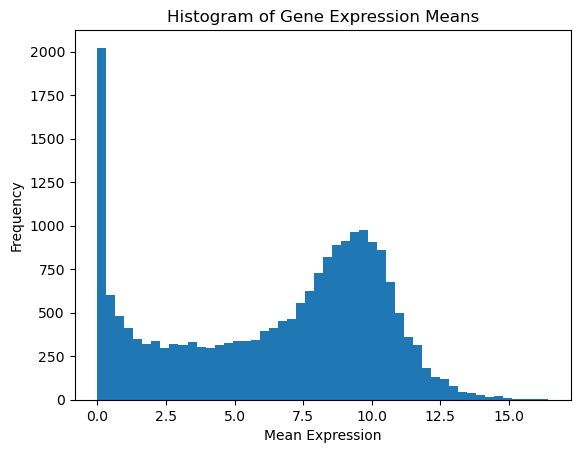

In [21]:
# Calculate the mean for each gene (column)
meanGene = np.mean(geneExpression, axis=0)

# histogram
plt.hist(meanGene, bins=50)
plt.title('Histogram of Gene Expression Means')
plt.xlabel('Mean Expression')
plt.ylabel('Frequency')
plt.show()

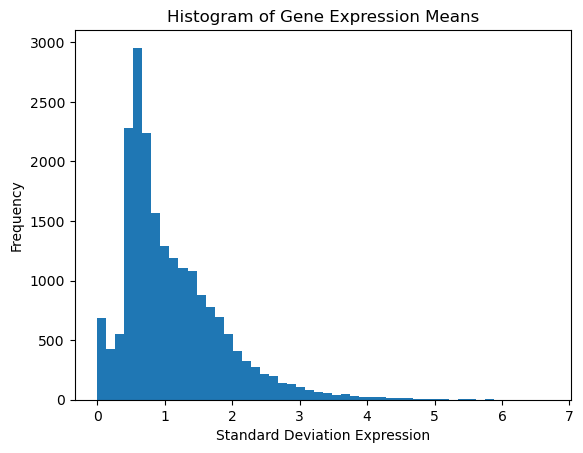

In [22]:
# Calculate standard deviation
stdGene = np.std(geneExpression, axis=0)

# histogram
plt.hist(stdGene, bins=50)
plt.title('Histogram of Gene Expression Means')
plt.xlabel('Standard Deviation Expression')
plt.ylabel('Frequency')
plt.show()

3. What do you observe from the distribution of the mean and standard deviation of gene
expression values? [0.5pt]


The mean distribution seems to have more of a gaussian distribution with the exception of the large frequency of 0s
in the data. 

The standard deviation distribution seems to have a strong right skewed distribution. 

4. Select 100 genes with the highest variance across samples and randomly select 100
samples. Save the selected subset (100 genes and 100 samples) to a CSV file for
clustering, and also save the corresponding labels subset for the selected samples to
another CSV file. [0.5pt]


In [68]:
# make dataframe combining labels and gene expression info
# read labels csv
labelDf = pd.read_csv('/Users/peytonhall/downloads/labels.csv')
classOnly = labelDf.iloc[:,1:]


# combine and then select top 100 genes with highest variance from this so they stay linked
# to the labels
labelGeneDf = pd.concat([geneExpression,classOnly],axis=1)

print(labelGeneDf)

     gene_0    gene_1    gene_2    gene_3     gene_4  gene_5    gene_6  \
0       0.0  2.017209  3.265527  5.478487  10.431999     0.0  7.175175   
1       0.0  0.592732  1.588421  7.586157   9.623011     0.0  6.816049   
2       0.0  3.511759  4.327199  6.881787   9.870730     0.0  6.972130   
3       0.0  3.663618  4.507649  6.659068  10.196184     0.0  7.843375   
4       0.0  2.655741  2.821547  6.539454   9.738265     0.0  6.566967   
..      ...       ...       ...       ...        ...     ...       ...   
796     0.0  1.865642  2.718197  7.350099  10.006003     0.0  6.764792   
797     0.0  3.942955  4.453807  6.346597  10.056868     0.0  7.320331   
798     0.0  3.249582  3.707492  8.185901   9.504082     0.0  7.536589   
799     0.0  2.590339  2.787976  7.318624   9.987136     0.0  9.213464   
800     0.0  2.325242  3.805932  6.530246   9.560367     0.0  7.957027   

       gene_7  gene_8  gene_9  ...  gene_20522  gene_20523  gene_20524  \
0    0.591871     0.0     0.0  ...   

In [52]:
# this is everything BUT the labels to find the 
print(labelGeneDf.iloc[:,:-1])

    0         1         2         3          4     5         6         7      \
0     0.0  2.017209  3.265527  5.478487  10.431999   0.0  7.175175  0.591871   
1     0.0  0.592732  1.588421  7.586157   9.623011   0.0  6.816049       0.0   
2     0.0  3.511759  4.327199  6.881787    9.87073   0.0   6.97213  0.452595   
3     0.0  3.663618  4.507649  6.659068  10.196184   0.0  7.843375  0.434882   
4     0.0  2.655741  2.821547  6.539454   9.738265   0.0  6.566967  0.360982   
..    ...       ...       ...       ...        ...   ...       ...       ...   
796   0.0  1.865642  2.718197  7.350099  10.006003   0.0  6.764792  0.496922   
797   0.0  3.942955  4.453807  6.346597  10.056868   0.0  7.320331       0.0   
798   0.0  3.249582  3.707492  8.185901   9.504082   0.0  7.536589  1.811101   
799   0.0  2.590339  2.787976  7.318624   9.987136   0.0  9.213464       0.0   
800   0.0  2.325242  3.805932  6.530246   9.560367   0.0  7.957027       0.0   

    8     9      ...     20521     2052

In [73]:
# identify top 100 genes with the highest variance
topGenes = geneExpression.var().nlargest(100).index

# select top 100 genes from geneExpression, should be [801 rows x 100 columns]
subsetGenes = geneExpression[topGenes]

# randomly select 100 samples from the subset
subsetSample = subsetGenes.sample(n=100,random_state=42)

# should get labels that correspond to the prev selection
subsetLabel = labelDf.loc[subsetSample.index]

In [77]:
# save the subsets to CSV

subsetSample.to_csv('/Users/peytonhall/Documents/2024_courses/pbhall_qbio_460/subsetGene7.csv',index=True)
subsetLabel.to_csv('/Users/peytonhall/Documents/2024_courses/pbhall_qbio_460/subsetLabel7.csv',index=True)

Part 2: K-means Clustering

1. Run the elbow method:
Use the elbow method to determine the optimal number of clusters K. Plot the
elbow curve and identify the optimal K. [0.5pt]

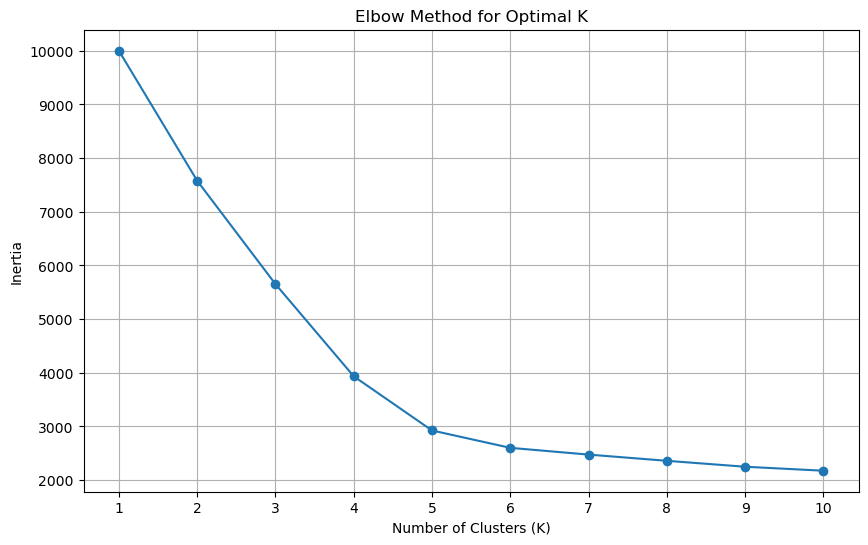

In [79]:
# load the selected subset of gene expression data
selectedSubset = pd.read_csv('/Users/peytonhall/Documents/2024_courses/pbhall_qbio_460/subsetGene7.csv', index_col=0)

# standardize the data
scaler = StandardScaler()
scaledData = scaler.fit_transform(selectedSubset)

# run K-Means for a range of K values
inertia = []
K = range(1, 11)  

for k in K:
    # ensures that the same randomization is used each time, n_init bc got error about 
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaledData)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.xticks(K)
plt.grid()
plt.show()

The optimal K was 4 since it is where increasing clusters cease to significantly reduce variance.
This point represents a balance between model simplicity and fit. 

In [111]:
# load the corresponding labels
labels = pd.read_csv('/Users/peytonhall/Documents/2024_courses/pbhall_qbio_460/subsetLabel7.csv', index_col=0)  

In [112]:
# i think we just want the labels not the samples
classNew = labels.iloc[:,1]

2. Apply K-means:
○ Run K-means clustering with the optimal K determined from the elbow method
and predict the cluster assignments. [0.5pt]

In [108]:
# initialize KMeans with K=4
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)

# fit the model and cluster the assignments
# holds the predicted cluster for each sample
cluster_assignments = kmeans.fit_predict(scaledData)

# shape is (100,) 100 cluster assignments 
"""
[3 0 3 2 0 0 0 3 1 3 3 0 3 1 2 3 3 1 0 3 3 3 2 0 0 0 3 0 1 1 0 1 1 3 0 0 3
 0 3 0 3 0 0 0 2 1 2 3 0 0 1 3 2 0 2 0 2 0 3 3 3 2 1 0 1 0 3 1 2 0 0 3 0 0
 0 3 1 1 2 0 2 0 0 2 3 0 0 1 3 3 3 2 0 0 0 1 3 3 3 0]
 """
print(cluster_assignments)

[3 0 3 2 0 0 0 3 1 3 3 0 3 1 2 3 3 1 0 3 3 3 2 0 0 0 3 0 1 1 0 1 1 3 0 0 3
 0 3 0 3 0 0 0 2 1 2 3 0 0 1 3 2 0 2 0 2 0 3 3 3 2 1 0 1 0 3 1 2 0 0 3 0 0
 0 3 1 1 2 0 2 0 0 2 3 0 0 1 3 3 3 2 0 0 0 1 3 3 3 0]


3. Evaluate performance:
○ Assess the performance of the clustering using Adjusted Rand Index (ARI).
Compare the predicted clusters with the true labels from labels.csv. [0.5pt]

In [133]:
# calculate ARI
kmeansARI = adjusted_rand_score(classNew, cluster_assignments)
print(kmeansARI)

0.8815748964803422


The ARI score for the clustering was 0.8815748964803422. This suggests good agreement 
between clustering and true labels. 

Part 3: Gaussian Mixture Model (GMM) Clustering

1. Apply GMM clustering:
Fit a Gaussian Mixture Model (GMM) to the RNA-seq data using the selected
100 genes and 100 samples.


In [117]:
# initialize
bic_scores = []
K = range(1, 15)  

# fit GMM for each value of K
for k in K:
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(scaledData)
    bic_scores.append(gmm.bic(scaledData))

Use the BIC (Bayesian Information Criterion) to evaluate different values of K
(the number of components) and plot the BIC scores to determine the optimal
number of components. [0.5pt]

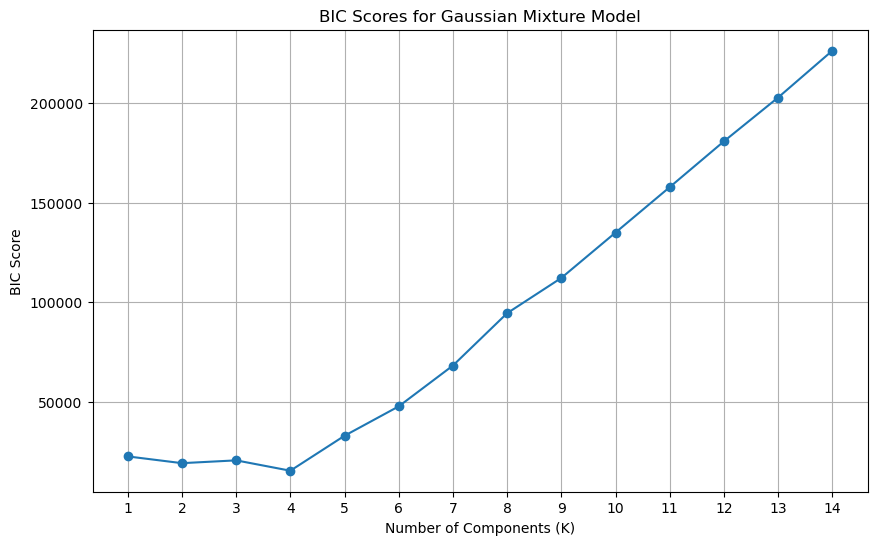

In [119]:
# Plot BIC scores
plt.figure(figsize=(10, 6))
plt.plot(K, bic_scores, marker='o')
plt.title('BIC Scores for Gaussian Mixture Model')
plt.xlabel('Number of Components (K)')
plt.ylabel('BIC Score')
plt.xticks(K)
plt.grid()
plt.show()

Best k is 4 components since this is the minimal BIC score.

2. Run GMM clustering with the optimal K:
After selecting the optimal number of components from the BIC plot, run GMM to
predict the cluster assignments. [0.5pt]


In [120]:
# run GMM with the optimal K
gmm = GaussianMixture(n_components=4, random_state=42)
gmm.fit(scaledData)

# assign cluster labels
gmmLabels = gmm.predict(scaledData)

print(gmmLabels)

[3 0 3 2 0 0 0 3 1 3 3 0 3 1 2 3 3 1 0 3 3 3 2 0 0 0 3 0 1 1 0 1 1 3 0 0 3
 0 3 0 3 0 0 0 2 1 2 3 0 0 1 3 2 0 2 0 2 0 3 3 3 2 1 0 1 0 3 1 2 0 0 3 0 0
 0 3 1 1 2 0 2 0 0 2 3 0 0 1 3 3 3 2 0 0 0 1 3 3 3 0]


3. Evaluate performance:
○ Assess the clustering performance using Adjusted Rand Index (ARI) to
compare the predicted clusters with the true labels. [0.5pt]

In [121]:
gmmARI = adjusted_rand_score(classNew, gmmLabels)
print(gmmARI)

0.8815748964803422


The ARI score for the clustering was 0.8815748964803422. This also suggests good agreement between clustering and true labels.

Part 4: Hierarchical Clustering

1. Apply hierarchical clustering:
○ Perform agglomerative hierarchical clustering on the RNA-seq data using the
selected 100 genes and 100 samples.

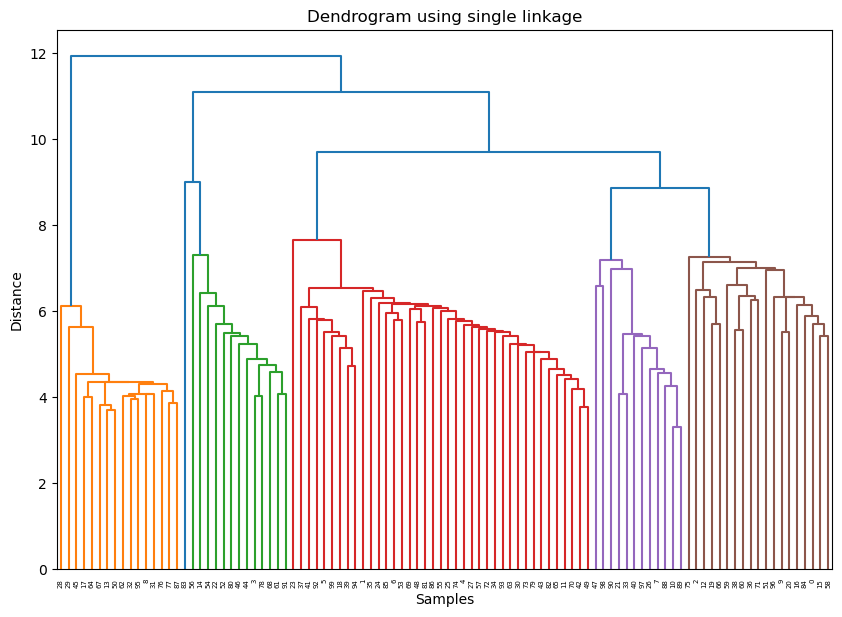

ARI Score for single linkage: 0.8743818601909433


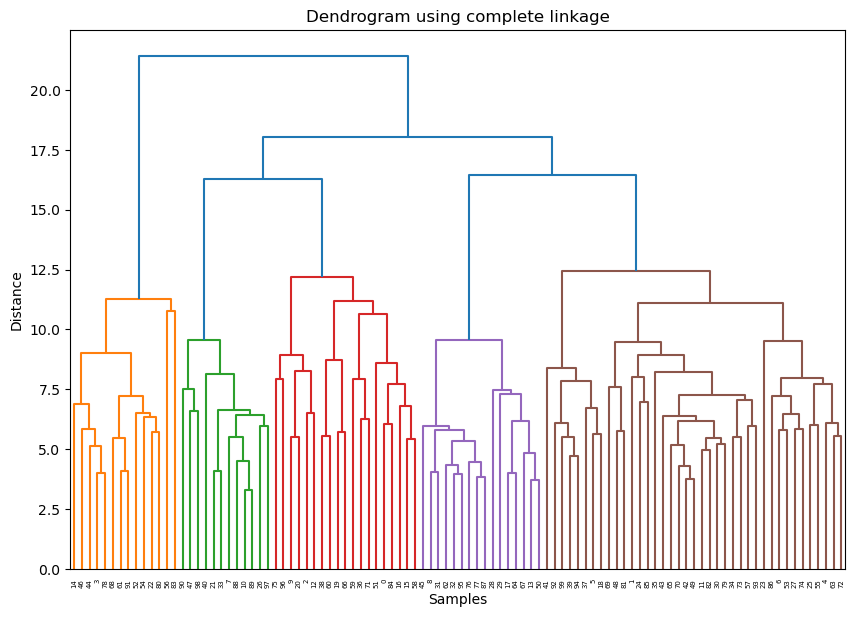

ARI Score for complete linkage: 1.0


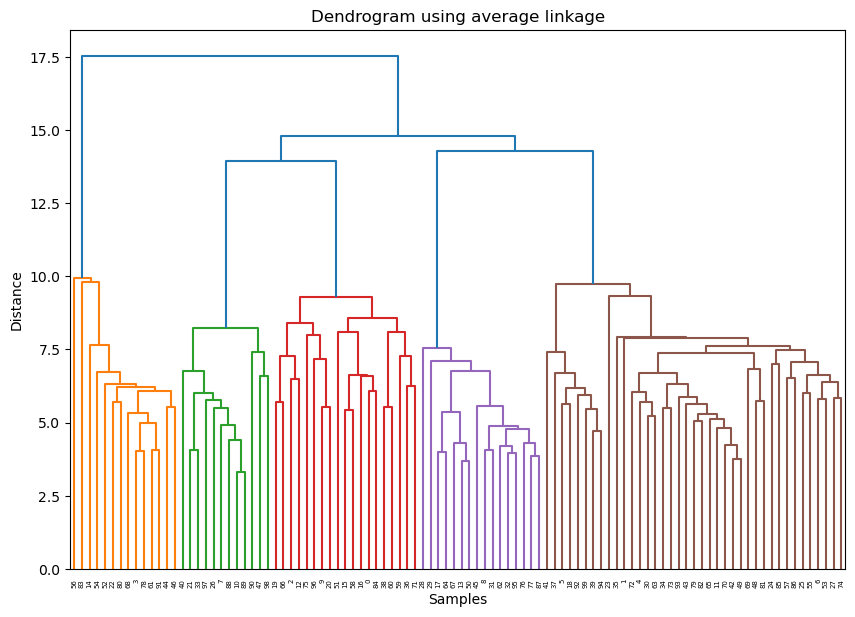

ARI Score for average linkage: 1.0


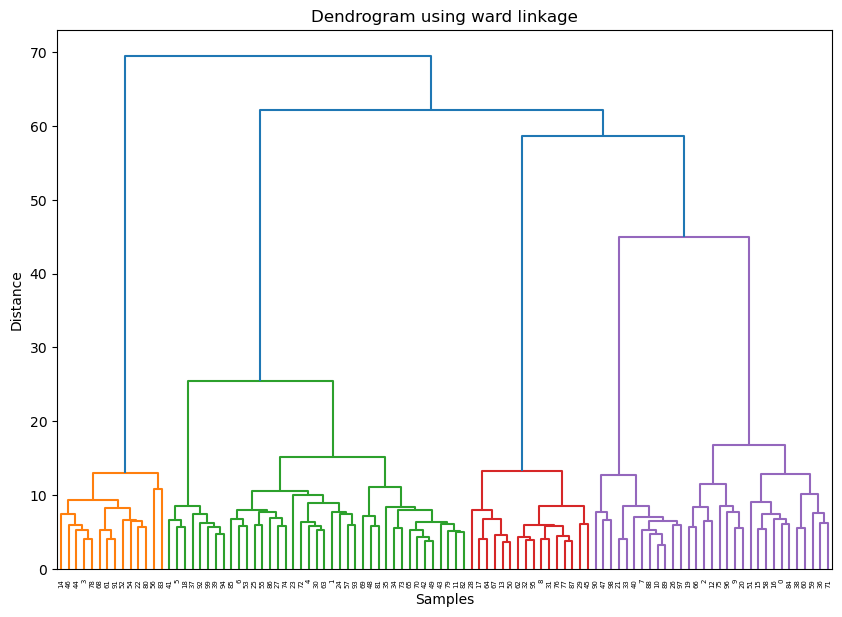

ARI Score for ward linkage: 1.0


In [134]:
linkage_methods = ['single', 'complete', 'average', 'ward']
num_clusters = 5  # I chose 5 because most methods showed 5 distinct clusters.

# dict to store ARI scores for each linkage method
ari_scores = {}

for method in linkage_methods:
    # perform hierarchical clustering
    Z = linkage(scaledData, method=method)
    
    # plot dendrogram for each method
    plt.figure(figsize=(10, 7))
    dendrogram(Z)
    # format to identify method
    plt.title(f"Dendrogram using {method} linkage")
    plt.xlabel("Samples")
    plt.ylabel("Distance")
    plt.show()
    
    # assign cluster labels
    cluster_labels = fcluster(Z, t=num_clusters, criterion='maxclust')
    
    # get ARI score per method
    ari_score = adjusted_rand_score(classNew, cluster_labels)
    ari_scores[method] = ari_score 
    
    # format again to show ARI scores per linkage
    print(f"ARI Score for {method} linkage: {ari_score}")

In [129]:
num_clusters = 5
# I chose 5 because most methods showed 5 distinct clusters.

# assign cluster labels
cluster_labels = fcluster(averageZ, t=num_clusters, criterion='maxclust')

# print the cluster labels
print(cluster_labels)

[3 5 3 1 5 5 5 2 4 3 2 5 3 4 1 3 3 4 5 3 3 2 1 5 5 5 2 5 4 4 5 4 4 2 5 5 3
 5 3 5 2 5 5 5 1 4 1 2 5 5 4 3 1 5 1 5 1 5 3 3 3 1 4 5 4 5 3 4 1 5 5 3 5 5
 5 3 4 4 1 5 1 5 5 1 3 5 5 4 2 2 2 1 5 5 5 4 3 2 2 5]


Part 5: ARI and Linkage Comparison

1. Compare ARI scores:
○ Collect and compare the ARI scores from K-means, GMM, and Hierarchical
Clustering (with different linkage methods). [0.5pt]

In [135]:
# dict with  ARI scores for each method
ariDict = {
    "Method": ["K-means", "GMM", "Hierarchical (Single Linkage)", 
               "Hierarchical (Complete Linkage)", "Hierarchical (Average Linkage)", 
               "Hierarchical (Ward’s Linkage)"],
    "ARI Score": [kmeansARI, gmmARI, ari_scores['single'], 
                  ari_scores['complete'], ari_scores['average'], ari_scores['ward']]
}

# convert to pd df
ariDf = pd.DataFrame(ariDict)

# print table
print(ariDf)

                            Method  ARI Score
0                          K-means   0.881575
1                              GMM   0.881575
2    Hierarchical (Single Linkage)   0.874382
3  Hierarchical (Complete Linkage)   1.000000
4   Hierarchical (Average Linkage)   1.000000
5    Hierarchical (Ward’s Linkage)   1.000000


Based on ARI scores, I would reccomend the hierarchical method and either complete, average, or ward's linkage methods. They all had an ARI score of 1, indicating perfect agreement between clustering and true labels.